# Visualizing Uncertainty
## Understanding Uncertainty

In [6]:
import urllib.request
import os

def download_data(force=False):
    """Download and extract course data from Zenodo."""
    import urllib.request
    import zipfile
    import os
    
    zip_path = 'data.zip'
    data_dir = 'data'
    
    if not os.path.exists(zip_path) or force:
        print("Downloading course data...")
        urllib.request.urlretrieve(
            'https://zenodo.org/records/16954427/files/data.zip?download=1',
            zip_path
        )
        print("Download complete")
    
    if not os.path.exists(data_dir):
        print("Extracting data files...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)
        print("Data extracted")
    
    return data_dir

download_data()


Extracting data files...
Data extracted


'data'

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('./data/metabric.csv') # Metabric Cancer Data
idf = pd.read_csv('./data/iowa.csv') # Iowa Liquor Sales Data
vdf = pd.read_csv('./data/va_procurement.csv') # Virginia Procurement Data
#mdf = pd.read_csv('./data/')

## Introduction
- We have three basic questions:
    - Which one? (categorical)
    - How much? (numeric)
    - When? (temporal)
- Data Science borrows a core idea of statistics: If the future is reasonably like the past, then we can predict future outcomes by using the appropriate past data. "In previous situations like this one, what happened?"
- In order to operationalize this idea, we need to be able to model and quantify past experience.
- To start the course, we focus on non-parametric methods: Models of uncertainty that use as little model as possible, in order to let the data "speak for itself"

## Workflow
Typically, we have:

1. Data
2. Model: Linear, Generalize Linear, Tree, Random Forest, 
3. Loss Function: SSE, MAD, Binary Cross Entropy, Categorical Cross Entropy, F1, etc.
4. Optimization/Estimation: Gradient Descent
5. Prediction: $\hat{y} = m(x,\hat{\theta})$

In this course, the goal is to ground this pipeline from data to prediction in the theory of probability

## Our Data
- `metabric.csv`: Data on breast cancer patients and survival duration
- `iowa.csc`: A subsample of all sales of liquor in Iowa
- `va_procurement.csv`: A subsample of all contracts procured by Virginia

Let's take a few minutes and look at the first few rows, and talk about what kinds of questions the data could answer

In [1]:
df.head()

NameError: name 'df' is not defined

In [1]:
idf.head()

NameError: name 'idf' is not defined

In [27]:
vdf.head()

,Unnamed: 0,Entity Description,NIGP #,NIGP Description,Item Description,Order #,Quantity Ordered,Unit Price,Unit of Measure,Line Total,Order Status,Procurement Transaction Type,Procurement Transaction Desc,Vendor Name,Vendor Address State
0,1209821,Virginia Polytechnic Institute and State Unive...,91577.0,"Telephone Services, Long Distance and Local (I...",-10K 14-17' DF IND FORKLIFT0550610,A208_P4426539,1.0,1895.00,EA,1895.00,Ordered,99.0,IMPORT,Sunbelt Rentals Inc,VA
1,1511053,Virginia Department of Energy,20468.0,"Peripherals, Miscellaneous: Joy Sticks, Graphi...",Fellowes Microbanreg Mouse Pad - Black,PCO04672013,12.0,5.00,EA,60.00,Ordered,20.0,Supplies - Non-Technology,TSRC - State of VA,VA
2,410883,Department of Corrections - Academy,38542.0,"Entrees, Meat (Includes Beef and Pork)",Performance Foodservice Invoice# 5219606 Del...,PO04394339,1.0,234.20,LO,234.20,Ordered,20.0,Supplies - Non-Technology,Performance Foodservice VA,VA
3,1360394,Old Dominion University,49000.0,"LABORATORY EQUIPMENT, ACCESSORIES AND SUPPLIES...",SystemETF# ********* RS020 Ø1 TappedPostS...,PO04579739-V2,3.0,11.51,EA,34.53,Ordered,15.0,Equipment - Technology,ThorLabs Inc,NJ
4,1180847,Longwood University,5000.0,ART EQUIPMENT AND SUPPLIES,"Scotch Multi-Purpose Scissors, 7 Inches, Strai...",PO04601721,74.0,3.57,EA,264.18,Ordered,20.0,Supplies - Non-Technology,School Specialty LLC,WI


## Proportions are Probability Estimates
- Intuitively --- and we'll spend more time on this later --- proportions are probability estimates
- What we are doing is using past proportions to estimate future probabilities: If x% of past cases were purple, x% of future cases are probably purple
- Something to consider: Because they are estimates, they are probably wrong. How do we quantify this uncertainty?

# Question: Which one?

## Categorical Variables
A **categorical variable** is one that takes on a finite number of values, that typically does not change with the size of the dataset or arrival of new data:
- Binary/dummy: Alive or dead, full-time employed or not, pregnant or not, etc.
- Multinomial: Brand of car, species of animal, type of cancer, color, city or state, highest degree conferred, zip code, etc.

These aren't numeric and they aren't typically ordered: There's no inherent structure to them, beyond the labels themselves 

## Countplot, Barplot
- In a given scenario, we want to know: Given what we know, what are the possible outcomes, and how likely are they?
- We can pretty faithfully make sense of a categorical variable by making simple bar graphs
- Let's look at counts of living versus deceased among breast cancer patients
- Very simple "which" question: Life or death?

<Axes: xlabel='count', ylabel='Overall Survival Status'>

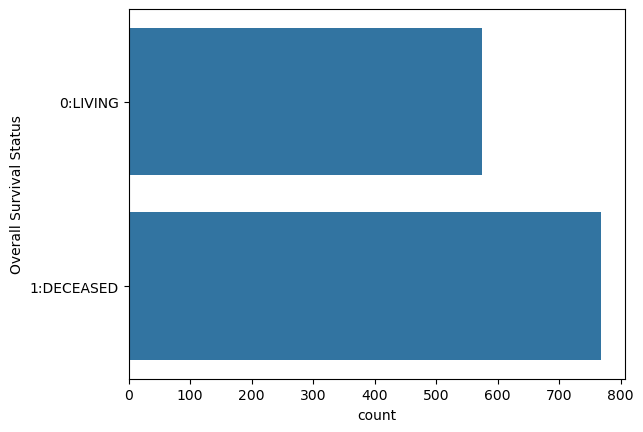

In [2]:
sns.countplot(df['Overall Survival Status'])

<Axes: xlabel='proportion', ylabel='Overall Survival Status'>

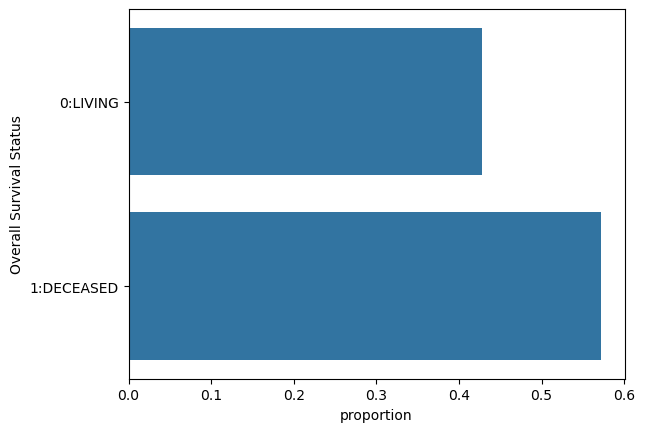

In [3]:
sns.countplot(data=df, y='Overall Survival Status', stat='proportion') # or stat='percent'

- So about 55% of the patients treated are still alive. Does that mean that 55% of people with breast cancer survive?
- To be fair, everyone dies eventually?
- We'll come back to this issue later, because questions over time are particularly difficult to parse

In [4]:
df['Overall Survival (Months)'].describe()

count    1343.000000
mean      129.094291
std        78.290236
min         0.100000
25%        62.700000
50%       118.533333
75%       191.200000
max       351.000000
Name: Overall Survival (Months), dtype: float64

## What's the most popular liquor in Iowa?
The prediction question is, "A person walks into a liquor store. What do they buy?"

How do you go about answering that question?
- Most bottles sold?
- Most dollars spent?
- Most liquid volume sold/presumably consumed?
- ...?



In [5]:
print(f'Shape: {idf.shape}')
print(f'Columns: {idf.columns}')
idf.head()

Shape: (159904, 14)
Columns: Index(['Invoice/Item Number', 'Date', 'Store Number', 'Store Name', 'Zip Code',
       'Category Name', 'Vendor Name', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Sale (Dollars)'],
      dtype='object')


,Invoice/Item Number,Date,Store Number,Store Name,Zip Code,Category Name,Vendor Name,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars)
0,INV-59108400026,06/06/2023,3723,J D SPIRITS LIQUOR,51040,STRAIGHT RYE WHISKIES,INFINIUM SPIRITS,27102,TEMPLETON RYE 4YR,750,18.09,27.14,2,54.28
1,S16879800057,01/16/2014,3926,LIQUOR DOWNTOWN / IOWA CITY,52240,VODKA 80 PROOF,HEAVEN HILL BRANDS,35416,BURNETT'S VODKA 80 PRF,750,4.84,7.26,12,87.12
2,INV-05301100019,06/05/2017,3829,GARY'S FOODS / MT VERNON,52314,CANADIAN WHISKIES,DIAGEO AMERICAS,11296,CROWN ROYAL,750,15.59,23.39,6,135.66
3,INV-40973500083,10/14/2021,5102,WILKIE LIQUORS,52314,AMERICAN SCHNAPPS,JIM BEAM BRANDS,82787,DEKUYPER BUTTERSHOTS,1000,7.87,11.81,12,141.72
4,INV-17022500013,01/18/2019,2560,HY-VEE FOOD STORE / MARION,52302,WHISKEY LIQUEUR,SAZERAC COMPANY INC,64863,FIREBALL CINNAMON WHISKEY,200,2.50,3.75,12,45.00


<Axes: xlabel='Bottles Sold', ylabel='Item Description'>

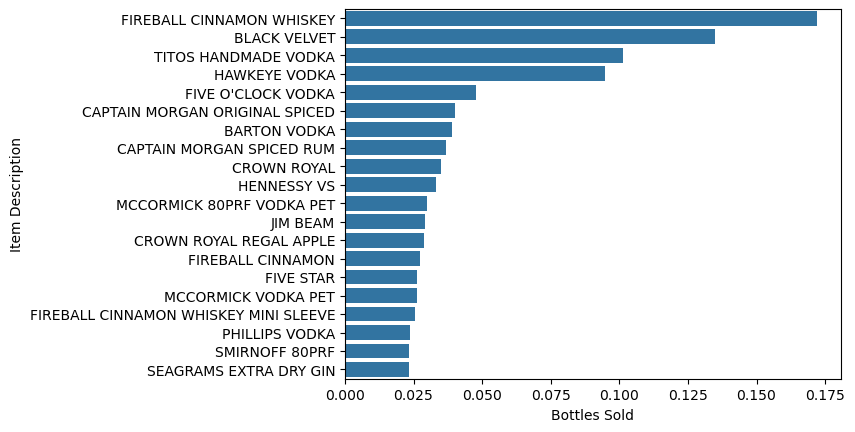

In [6]:
bottles = (idf.loc[:,['Bottles Sold','Item Description']]
         .groupby('Item Description')
         .sum()
         .sort_values(by='Bottles Sold',ascending=False) )

top_bottles = bottles[:20]
sns.barplot(top_bottles['Bottles Sold']/np.sum(top_bottles['Bottles Sold']), orient = 'h')

<Axes: xlabel='Sale (Dollars)', ylabel='Item Description'>

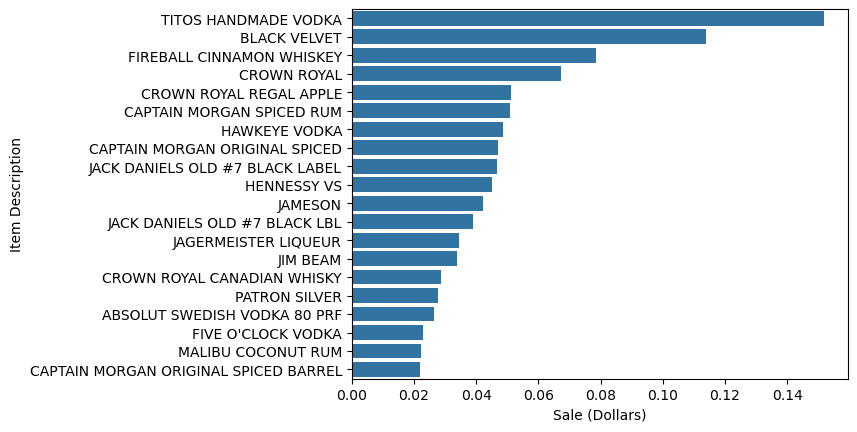

In [7]:
sales = (idf.loc[:,['Sale (Dollars)','Item Description']]
         .groupby('Item Description')
         .sum()
         .sort_values(by='Sale (Dollars)',ascending=False) )

top_sales = sales[:20]
sns.barplot(top_sales['Sale (Dollars)']/np.sum(top_sales['Sale (Dollars)']), orient = 'h')

<Axes: xlabel='Percent Volume', ylabel='Item Description'>

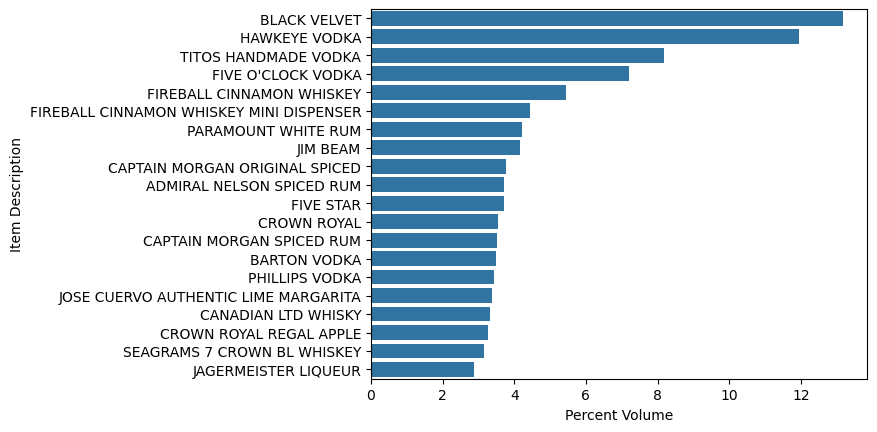

In [8]:
volume = ( (idf.loc[:,['Bottle Volume (ml)','Item Description']])
         .groupby('Item Description')
         .sum()
         .sort_values(by='Bottle Volume (ml)',ascending=False))

top_volume = volume[:20].copy()
top_volume['Percent Volume'] = 100 * top_volume['Bottle Volume (ml)'] / top_volume['Bottle Volume (ml)'].sum()

sns.barplot(
    data=top_volume.reset_index(),
    x='Percent Volume',
    y='Item Description',
    orient='h'
)


In some sense, all of these answers might make sense. In order to pick one, we need a clearer idea about what the specific question is.

## Exercise 1: Most Profitable Item?
Let's take a pause to play with these data. 

'State Bottle Retail' is the price at which the bottle is sold, while 'State Bottle Cost' is the price the state pays for a bottle.


Which item is most profitable? How do we define this concept?
- Total Revenue is price times quantity
- Mark-up is price minus cost
- Total Profit is mark-up times quantity


# Question: How much?

## Numeric Variables
- **Numeric variables** typically take many values, and more data typically means more values and many sparse/small bins: A barplot or table is inappropriate for conceptualizing what's going on, there's just too many labels
- Because there are so many values, these variables are inherently hard to understand: What outcomes are likely? Is one variable more or less "uncertain" than another? 
- A **rugplot** is a one-dimensional scatterplot, and illustrates the concentration of values in the data

<Axes: xlabel='Age at Diagnosis'>

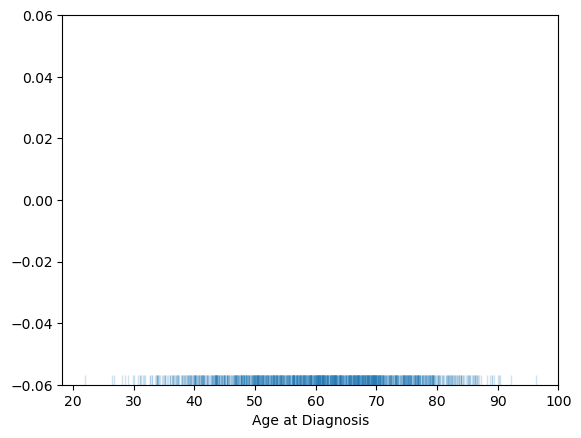

In [9]:
sns.rugplot(df['Age at Diagnosis'], alpha = .2)

## Visualizing a Numeric Variable
- The best tool from the perspective of probability is something called the Empirical Cumulative Distribution Function, and it will be a recurring object throughout the class
- The rugplot is just not very descriptive: It's noisy, inexpressive, hard to interpret
- Imagine that we sweep a threshold value $z$ up and down in the domain of the data, count how many cases are below the threshold, and normalize by the sample size
- The formula for this is the **ECDF**:
$$
\hat{F}_N(z) = \dfrac{1}{N} \sum_{i=1}^N \mathbb{I}\{ x_i \le z\}
$$ 
- How do we calculate this thing in a clever way?

## NumPy: Broadcasting 
- In principle we can compute $\mathbb{I}\{x_i \le z\}$ using double loops over $x_i$ and $z_j$ but this will be slow in Python
- But Numpy is a very clever tool
- We often have two vectors, $x = (x_1, ..., x_N)$ and $y = (y_1, ..., y_J)$, and want to compare or difference their values for every pair $(x_i, y_j)$; this might be $\le$, or $-$, or $\max$...
- By manipulating how Numpy perceives their dimensions, we can get a variety of results easily 

## Broadcasting
For the less-than comparison:
$$
\underbrace{[x_1, x_2, ..., x_N]}_{\text{x.reshape(1,-1)}} \le \underbrace{\left[ \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_J \end{array} \right]}_{\text{y.reshape(-1,1)}} = \left[ \begin{array}{cccc}
x_1 \le y_1 & x_2 \le y_1 & \dots & x_N \le y_1 \\
x_1 \le y_2 & x_2 \le y_2 & \dots & x_N \le y_2 \\
\vdots & \vdots & \ddots & \vdots \\
x_1 \le y_L & x_2 \le y_L & \dots & x_N \le y_L \\
\end{array}\right]
$$
For squared difference:
$$
\left(\underbrace{[x_1, x_2, ..., x_N]}_{\text{x.reshape(1,-1)}} - \underbrace{\left[ \begin{array}{c} y_1 \\ y_2 \\ \vdots \\ y_J \end{array} \right]}_{\text{y.reshape(-1,1)}}\right) **2 = \left[ \begin{array}{cccc}
(x_1 - y_1)^2 & (x_2 - y_1)^2 & \dots & (x_N - y_1)^2 \\
(x_1 - y_2)^2 & (x_2 - y_2)^2 & \dots & (x_N - y_2)^2 \\
\vdots & \vdots & \ddots & \vdots \\
(x_1 - y_L)^2 & (x_2 - y_L)^2 & \dots & (x_N - y_L)^2 \\
\end{array}\right]
$$

In [10]:
x = df['Age at Diagnosis']

# Naive double loops
def L(x):
    Z = np.sort(x.unique()) # Extract and sort unique values for x
    L = np.zeros((len(Z),len(x)))
    for j in range(len(Z)):
        for i in range(len(x)):
            L[j,i] = (x[i] <= Z[j])
    return L
print('Naive double loop:')
%timeit L(x)

# Loop with a list comprehension
def L(x):
    Z = np.sort(x.unique()) # Extract and sort unique values for x
    L = []
    for z in Z:
        row = [ x_i <= z for x_i in x]
        L.append(row)
    return L
print('Loop with List Comprehension:')
%timeit L(x)

# Broadcasting with numpy
def L(x):
    Z = np.sort(x.unique()) # Extract and sort unique values for x
    L = x.to_numpy().reshape(-1,1) <= Z.reshape(1,-1) # Compare x and Z values
    return L
print('Broadcasting:')
%timeit L(x)

Naive double loop:
2.63 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Loop with List Comprehension:
159 ms ± 11.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
Broadcasting:
1.07 ms ± 50.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Numba
- Sometimes you can't broadcast, and need to do a complex under-the-hood computation in loops
- Is there a way to accelerate it?
- Numba is a library that does just-in-time compiling of functions and parallelizes computation in order to accelerate code
- Does Numba perform better or worse than NumPy broadcasting?

In [11]:
import numba
from numba import prange

x_np = x.to_numpy() # Essentially all objects must be NumPy objects to use Numba

@numba.njit(parallel=True) # Ask numba to compile the next function
def L(x):
    Z = np.sort(np.unique(x))
    m = Z.shape[0]
    n = x.shape[0]
    L = np.zeros((m, n)) # Preallocate array
    for j in prange(m): # Parallelized but double loops
        zj = Z[j]
        for i in range(n):
            L[j, i] = 1 if x[i] <= zj else 0
    return L

L(x_np) # Esnure the code is compiled

%timeit L(x_np)

1.74 ms ± 172 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


## Python is a challenging language
- I do not think Python is an easy language to use, unless you're doing very "batteries included" kinds of tasks
- What you see here is that, with Python, code performance can vary wildly with implementation
- In compiled languages (and Numba), these differences typically disappear: Python's performance issues are because it has to compile code each time it goes into the loop and each such mini-compilation has a fixed cost
- Numba compiles Numpy code, so that it performs competitively with C/C++, but this requires very strict adherence to NumPy (e.g. no Pandas)
- It is worth thinking about how your code performs, but trying to optimize before you know what you're doing is its own source of problems: If you need to write loops to keep moving forward, just do it and worry about optimization later
- This gives me the general opinion that, contrary to what people say, Python can be a hard language to work with: Doing the "obvious" thing gets punished, in terms of performance

## The ECDF
- With broadcasting, we can quickly compute ECDFs:

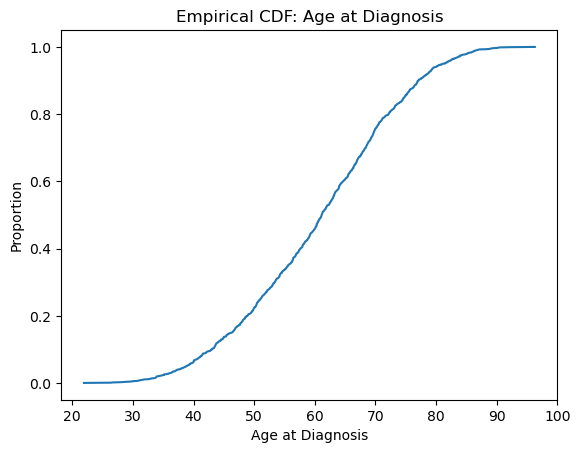

In [12]:
def ecdf(x, plot = True):
    # Compute ecdf function:
    Z = np.sort(x.unique()) # Extract and sort unique values for x
    compare = x.to_numpy().reshape(-1,1) <= Z.reshape(1,-1) # Compare x and Z values
    
    ecdf = np.mean(compare,axis=0) # Average over x indices for each z
    
    if plot:
        # Plot the ecdf:
        title_str = x.name
        plt.plot(Z,ecdf)
        plt.title(f'Empirical CDF: {title_str}')
        plt.ylabel('Proportion')
        plt.xlabel(title_str)

    return ecdf, Z

F_hat, grid = ecdf(df['Age at Diagnosis'])

<Axes: xlabel='Age at Diagnosis', ylabel='Proportion'>

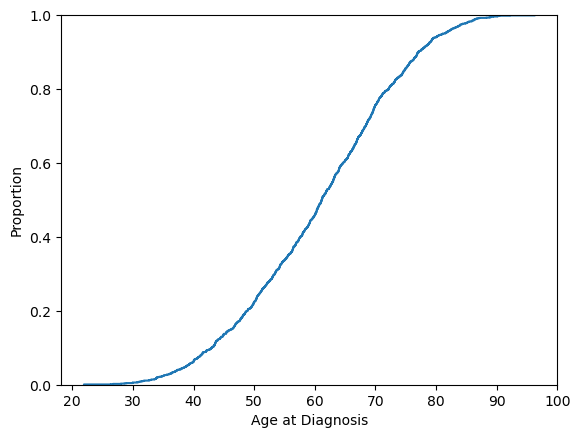

In [13]:
sns.ecdfplot(df['Age at Diagnosis']) # Seaborn's version

## Accumulation 
- This plot represents uncertainty, randomness, stochastic volatility
- As we "sweep" values from left to right, we accumulate proportions of the population
- This maps out the areas of possibility and uncertainty
- It is unambiguous about values at which the ECDF quickly increases (meaning significant observations), unlike the rugplot

## A Prediction Problem
- What do you think is going to happen?
- If we predict $\hat{x}$ and $x'$ occurs, the distance is $|x' - \hat{x}|$; this is the **absolute deviation**
- Let's minimize the **mean absolute deviation** of our prediction, $\hat{x}$, from the data:
$$
\begin{alignat*}{2}
MAD(\hat{x}) &=&  \frac{1}{N} \sum_{i=1}^N | x_i - \hat{x} | \\
&=&  \frac{1}{N} \sum_{x_i \le \hat{x} } (\hat{x}-x_i)  + \frac{1}{N} \sum_{x_i > \hat{x} } (x_i - \hat{x})
\end{alignat*}
$$
- We call this a **loss function**: If we predict $\hat{x}$ but the data that arrive are distributed similarly to the past, this is our expected absolute deviation
- What does $MAD(\hat{x})$ typically look like?

Text(0, 0.5, 'MAD')

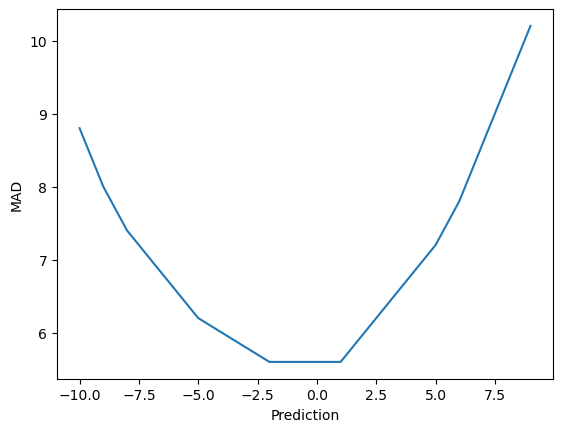

In [14]:
import numpy as np
import matplotlib.pyplot as plt

N = 10
rng = np.random.default_rng(100)
X = rng.integers(-10,10,N)
x_grid = np.arange(-10,10,1)

def mad(X,x_grid):
    N = len(X)
    vals = X.reshape(1,-1)
    grid = x_grid.reshape(-1,1)
    deviations = (vals>grid)*(vals-grid) + (vals<=grid)*(grid-vals)
    mad = np.mean(deviations,axis = 1)
    return mad

mad_values = mad(X,x_grid)

plt.plot(x_grid, mad_values)
# for xi, yi in zip(x_grid, mad_values):
#     plt.text(xi, yi + 0.15, f'{len(X)*yi}', ha='center', va='bottom', fontsize=10)
plt.xlabel('Prediction')
plt.ylabel('MAD')


- This function isn't differentiable everywhere because of the "kinks": But off the kinks, the slope is the net number of observerations above or below $\hat{x}$:
$$
\partial MAD(\hat{x}) = \dfrac{1}{N}\sum_{i=1}^N \text{sign}(x_i - \hat{x}),
$$
- Let's plot that function to visualize what's going on, and look for its zeros

Text(0, 0.5, 'Gradient')

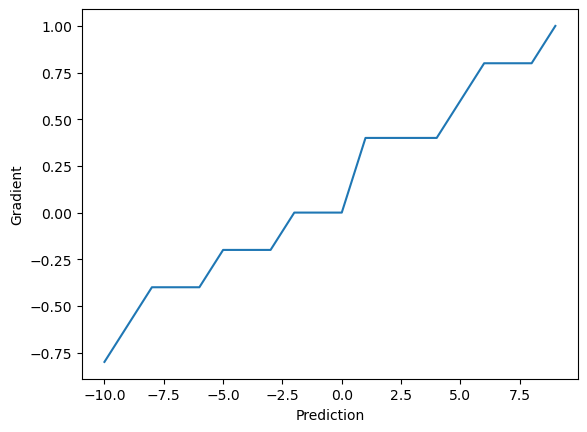

In [15]:
def mad_grad(X,x_grid):
    N = len(X)
    vals = X.reshape(1,-1)
    grid = x_grid.reshape(-1,1)
    deviations = (vals>grid)*(-1.0) + (vals<=grid)*(+1.0)
    grad = np.mean(deviations,axis = 1)
    return grad

plt.plot(x_grid,mad_grad(X,x_grid) )
plt.xlabel('Prediction')
plt.ylabel('Gradient')

## What happens when the gradient equals zero?
- Let's put the reasoning together
- If
$$
MAD(\hat{x}) = \frac{1}{N}\sum_{i=1}^N | x_i - \hat{x} |,
$$
then the subgradient is
$$
\partial MAD(\hat{x}) = \frac{1}{N} \sum_{i=1}^N \text{sign}( x_i - \hat{x} ) = \frac{1}{N} \sum_{i=1}^N \mathbb{I}\{ x_i \le \hat{x}\} -\frac{1}{N} \sum_{i=1}^N \mathbb{I}\{ x_i > \hat{x}\}
$$
and $\partial MAD(\hat{x}^*)$ is approximately/contains zero when
$$
\frac{1}{N} \sum_{i=1}^N \mathbb{I}\{ x_i \le \hat{x} \} \approx \frac{1}{N} \sum_{i=1}^N \mathbb{I}\{ x_i > \hat{x} \} = 1 - \frac{1}{N} \sum_{i=1}^N \mathbb{I}\{ x_i \le \hat{x} \}
$$
- Notice, this is: $\hat{x}^*$ is optimal if:
$$
\hat{F}_N(\hat{x}) \approx 1-\hat{F}_N(\hat{x}) \quad \rightarrow \quad \hat{F}_N(\hat{x}) \approx \frac{1}{2}
$$
This says, "$\hat{x}$ is a minimizer of MAD if roughly half the sample is above $\hat{x}$ and half the sample is below $\hat{x}$"
- This is called the **sample median**, where $\hat{F}_N(\hat{x}) \approx \frac{1}{2}$

## Estimation/Algorithms Are Almost Always Optimization
- Notice, we **derived** the median from a decision problem: Make a prediction ($\hat{x}$) that minimizes a loss function (mean absolute deviation)
- You're now a data scientist, so: All of your actions -- whether you're aware of it or not -- minimize some loss function. What separates "best" from "good" solutions is that they know what they're doing and why
- The rest of your time here is basically making the data and loss function more and more complex
- If you understand the optimization happening under the hood of algorithms, you will be light years ahead of your many of your competitors

## Computing the Median
- The median is often given by two values, when the loss function "bottoms out"

In [16]:
def compute_median(F_hat, grid):
    dist = (F_hat-.5) ** 2 # Compute squared distance of F_hat from .5
    meds = np.where( dist == dist.min() ) # Find the indices closest to 1/2
    print(grid[meds])
    median = np.mean(grid[meds])
    return median

print(compute_median(F_hat, grid))

def compute_median(F_hat, grid):
    # Find median index closest to .5
    idx = np.searchsorted(F_hat, 0.5)
    if idx == 0:
        return grid[0]
    elif idx == len(F_hat):
        return grid[-1]
    # Points just below and above the 0.5 threshold:
    x0, x1 = grid[idx - 1], grid[idx]
    y0, y1 = F_hat[idx - 1], F_hat[idx]
    # Linear interpolation for median:
    t = (0.5 - y0) / (y1 - y0)
    return x0 + t * (x1 - x0)

compute_median(F_hat, grid)

[61.12 61.14]
61.129999999999995


np.float64(61.129999999999995)

In [17]:
np.median(df['Age at Diagnosis']) # Using Numpy

np.float64(61.14)

## Exercise 2: Quantiles, IQR, Whiskers, Boxplot, Outliers
From the ECDF, we get a fairly good picture of the distribution of the data: A **quantile** adjusts the concept of the median so that instead of 50% of the mass below and 50% above, the $q$-quantile has $q$% of the mass below and $(1-q)$% of the mass above.

Write a Python class that:
- Computes the ECDF $\hat{F}_N(x)$
- Has a method to compute any quantile without using Numpy
- Has a method to compute the **Interquartile Range (IQR)** -- the .25 quantile and the .75 quantile, which brackets 50% of the data -- and the **whiskers**: $\pm 1.5 \times \text{IQR}$ from the edges of the IQR
- Has a method to compute a five-number summary/boxplot: the whiskers, the minimum and maximum, the IQR and the median
- Compare your answers with `sns.boxplot`; making a boxplot yourself is kind of a pain, but you could make a 5-number summary visualization
- Anything outside the whiskers is an **outlier**; write a method that returns a Boolean vector indicating if the observations are outliers

Then use your ECDF class to analyze numeric variables from a dataset of your choice

<Axes: xlabel='Age at Diagnosis'>

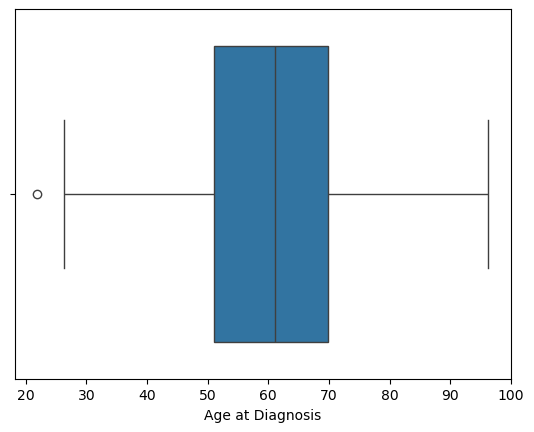

In [18]:
sns.boxplot(x,orient='h')

# Kernel Density Estimation

## Visualizing Concentration
- The ECDF is a great tool, and I promise, you will grow to -- if not love -- at least appreciate it
- For humans, its drawback is that it shows accumulation, not concentration
-  Which values are relatively more or less likely to occur?
- To visualize this slightly different concept, we use a related tool

## The Density Estimator
- Imagine we take tried taking the derivative of the ECDF:
$$
\dfrac{\hat{F}_X(z+h)- \hat{F}_X(z-h)}{2h} = \dfrac{1}{N} \sum_{i=1}^N \dfrac{\mathbb{I\{x_i \le z+h\}}-\mathbb{I\{x_i \le z - h\}}}{2h} = \hat{f}_{N,h}(z)
$$
where $h$ is called the **bandwidth**. This is called the **kernel density estimator**, $\hat{f}_{N,h}(x)$, or KDE
- Exercise: Show that the KDE is quivalent to
$$
\hat{f}_{X,h}(z) = \dfrac{1}{N} \sum_{i=1}^N \dfrac{\mathbb{I}\{  |z - x_i| \le h \}}{2h}
$$
(Hint: For the numerator to be non-zero, it must be the case that *both* $x_i > z - h$ and $ x_i \le z+h$, then use the definition of absolute value as $|w|<r \rightarrow -r < w <r$). What happens if $h \rightarrow 0$?

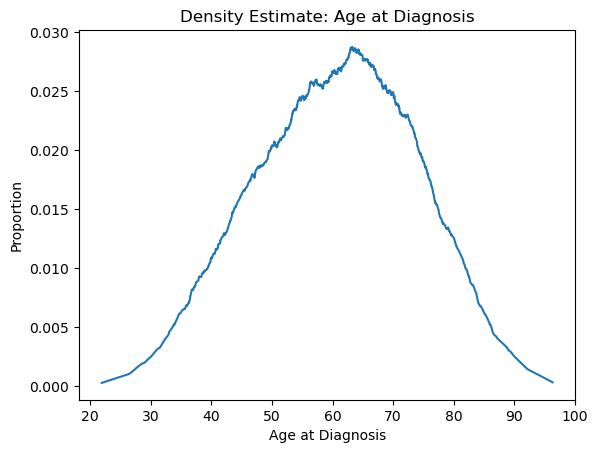

In [19]:
x = df['Age at Diagnosis']

def kde(x, h):
    Z = np.sort(x.unique()).reshape(1,-1) # Extract unique values for x
    data = x.to_numpy().reshape(-1,1) # Reshape the data
    I = np.abs( data-Z ) <= h # Compute the kernel
    kde = np.mean(I,axis=0)/(2*h) # Sum over x indices and normalize
    grid = Z.reshape(-1,1)

    # Plot KDE
    title_str = x.name
    plt.plot(grid,kde)
    plt.title(f'Density Estimate: {title_str}')
    plt.ylabel('Proportion')
    plt.xlabel(title_str)
    return kde, grid

f_hat, grid = kde(x,7)

## Squared Loss
- Let's make a prediction again, $\hat{x}$. This time, we'll minimize the **mean squared error**:
$$
MSE(\hat{x}) = \sum_{i=1}^N (x_i - \hat{x})^2 \hat{f}_{N,h}(x_i)
$$
- So we weight the squared deviation by the probability it occurs, and sum
- The first-order condition is
$$
\partial MSE(\hat{x}^*) = -2 \sum_{i=1}^N (x_i - \hat{x}^*) \hat{f}_{N,h}(x_i) = 0
$$
with solution
$$
\hat{x}^* = \dfrac{ \sum_{i=1}^N x_i \hat{f}_{N,h}(x_i) }{\sum_{i=1}^N \hat{f}_{N,h}(x_i) }
$$
- This is called the **sample expectation of $X$** (with respect to $\hat{f}_{N,h}(x)$)
- Notice that if you don't normalize your kernel density estimator so it sums to 1, this definition does that for you: This is a proper expectation
- The sample expectation of $X$ is almost the sample mean or sample average:
$$
m = \frac{1}{N} \sum_{i=1}^N x_i,
$$
the weighting is just more complicated.


In [20]:
expectation = f_hat @ grid / np.sum(f_hat)
print(f'Expectation: {expectation}')

Expectation: [61.29166931]


In [21]:
df['Age at Diagnosis'].describe()

count    1343.000000
mean       60.598079
std        12.966330
min        21.930000
25%        51.045000
50%        61.140000
75%        69.815000
max        96.290000
Name: Age at Diagnosis, dtype: float64

# Smoothing

## Kernel Smoothing
- The ECDF and KDE relied on indicator functions, which made our plots kind of bumpy
- In order to get smoother visualizations, we often replace the indicator functions with a smoother kernel, like the Gaussian or Epanechnikov
- Here's the classic example. Instead of 
$$
\hat{f}_{X,h}(z) = \dfrac{1}{N} \sum_{i=1}^N \dfrac{1}{h} \underbrace{\dfrac{\mathbb{I}\{  |z - x_i| \le h \}}{2}}_{\text{Uniform Kernel}},
$$
we use
$$
\hat{f}_{X,h}(z) = \dfrac{1}{N} \sum_{i=1}^N  \dfrac{1}{h} \underbrace{k\left( \dfrac{z - x_i}{h} \right)}_{\text{General Kernel}}
$$

## Kernels

There are four kernels that are commonly used:

| Kernel | Formula | Support | 
|--------|---------|---------|
| Gaussian (Normal) | $\frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}u^2}$ | $(-\infty, \infty)$ | 
| Epanechnikov | $\frac{3}{4}(1-u^2)$ | $[-1, 1]$ | 
| Uniform | $\frac{1}{2}$ | $[-1, 1]$ | 
| Triangular | $1 - \|u\| $ | $[-1, 1]$ | 

The key question is: Is your data roughly bell-shaped and a good fit for a Gaussian kernel, or do they have "gaps" or "hard boundaries" that make the Gaussian kernel inappropriate? If so, these other kernels might perform better

## Gaussian Kernel
- If you replace the kernel with the Gaussian function, you get
$$
\hat{f}_{X,h}(z) = \dfrac{1}{N} \sum_{i=1}^N \dfrac{1}{h} \underbrace{ \dfrac{1}{\sqrt{2\pi}} \exp \left( \left(\dfrac{z - x_i}{h}\right)^2 \right) }_{\text{Gaussian Kernel}}
$$
- This is by far the most common version of the kernel density estimator, which is somewhat unfortunate

## Plug-in Bandwidth
- The default choice for bandwidths is
$$
h_s = 1.06 \times s_X \times n^{-1/5},
$$
and often adjusted to
$$
h_r = 0.9 \times \min \left\lbrace s_X, \dfrac{IQR}{1.34} \right\rbrace \times n^{-1/5}
$$
to be more robust to outliers (extremely high or low values that don't fit the rest of the patterns of the data)
- This is derived as an approximation to the optimal bandwidth, and we'll look at data driven-approaches later

Bandwidth is: 2.7623750151352238


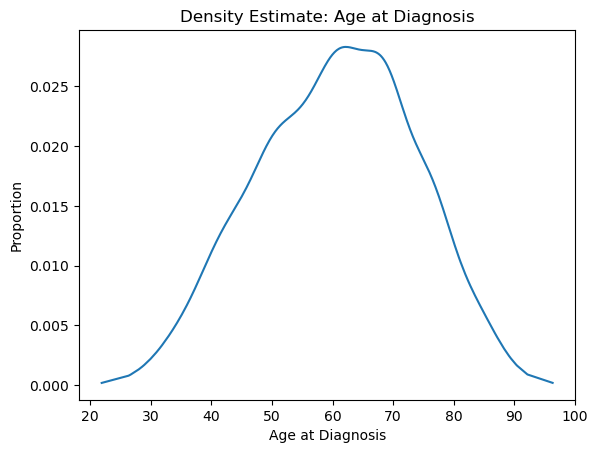

In [22]:
x = df['Age at Diagnosis']

def kde(x, plot = True):
    Z = np.sort(x.unique()).reshape(1,-1) # Extract unique values for x
    data = x.to_numpy().reshape(-1,1) # Reshape the data

    #h_s = 1.06 * np.std(x) * len(x)**(-0.2)
    iqr = np.quantile(x,.75) - np.quantile(x,.25)
    h_s = 0.9 * min(np.std(x), iqr/1.34) * len(x) **(-0.2)
    print(f'Bandwidth is: {h_s}')
    I = np.exp( -(data-Z)**2/(2*h_s**2) )/( np.sqrt(2*np.pi) * h_s) # Compute the kernel
    kde = np.mean(I,axis=0) # Sum over x indices and normalize
    #kde = kde/np.sum(kde) # Normalize the kde so it sums to 1
    grid = Z.reshape(-1,1)
    
    # Plot KDE
    if plot:
        title_str = x.name
        plt.plot(grid,kde)
        plt.title(f'Density Estimate: {title_str}')
        plt.ylabel('Proportion')
        plt.xlabel(title_str)
    return kde, grid

f_hat, grid = kde(x)

<Axes: xlabel='Age at Diagnosis', ylabel='Density'>

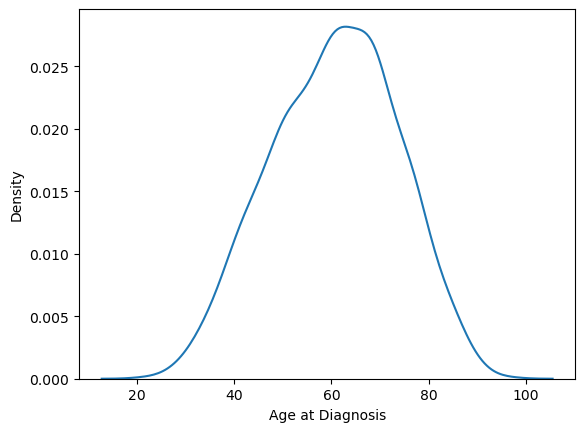

In [23]:
sns.kdeplot(x)


## What if we play with $h$?

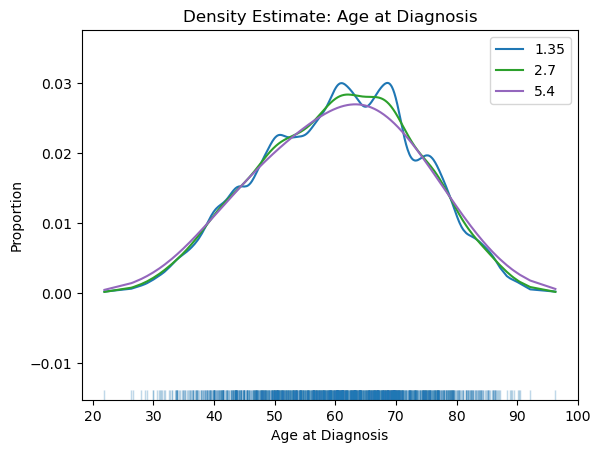

In [24]:
x = df['Age at Diagnosis']

def kde(x,h, plot = True):
    Z = np.sort(x.unique()).reshape(1,-1) # Extract unique values for x
    data = x.to_numpy().reshape(-1,1) # Reshape the data

    I = np.exp( -(data-Z)**2/(2*h**2) )/( np.sqrt(2*np.pi) * h) # Compute the kernel
    kde = np.mean(I,axis=0) # Sum over x indices and normalize
    grid = Z.reshape(-1,1)

    if plot:
        # Plot KDE
        title_str = x.name
        plt.plot(grid,kde, label = f'{h}')
        sns.rugplot(data,alpha=.1)
        plt.title(f'Density Estimate: {title_str}')
        plt.ylabel('Proportion')
        plt.xlabel(title_str)

    return kde, grid

h_grid = [ 1.35, 2.7, 5.4]
for h in h_grid:
    f_hat, grid = kde(x,h)

plt.legend() # Add legend
plt.show() # Render plot



## Overfitting and Underfitting
- We've already arrived at the central issue in machine learning
- Models often have hyperparameters like the bandwidth $h$ that give us degrees of freedom in tuning models: We learn about the underlying model and data by playing with it, but we typically don't have an obvious, uniquely best way to pick hyperparameters like $h$
    - When we pick a very tight bandwidth, the kernel density plot seems to be overconfident about how much information it can extract from the limited data available: This is called **overfitting**
    - When we pick a very wide bandwidth, the kernel density plot seems shapeless and timid about how much information it can extract from the data versus the model: This is called **underfitting**

## Bias-Variance Trade-Off
- What's happening here is a **bias-variance trade-off**: 
    - We can pick a very tight bandwidth to reduce bias... but the lack of smoothing makes the predictions very high variance (the model overfits the data)
    - We can pick a very wide bandwidth to reduce variance... but this excess smoothing makes the bias large (the model underfits the data)
    - We'll cover the bias-variance trade-off in depth later in the course, but this is a first glimpse of the concept
- The job of machine learning is largely to develop methods by which to fit models to data in ways that avoid overfitting and underfitting, and deliver consistent and reliable predictions
- While plug-in methods are nice, there are data-driven tools to pick the bandwidth that we'll cover later in the course (least squares cross validation, likelihood cross validation)

## Exercise 3: Timing and Broadcasting
- Use `@timeit` to compare how long it takes to do a double for loop to compute the values of the kernel, $\frac{1}{h} k \left( \frac{x_i - z_j}{h}\right)$, versus broadcasting with NumPy
- Does the time of the computation depend on the kernel?

## Exercise 4: A KDE Class
- Create a Python class that implements the KDE estimator
    1. Takes a vector of data, and returns $\hat{f}_{N,h}$ and the grid
    2. Makes a plot of the KDE
    3. Computes an automatic bandwidth, but can be overriden with a user-provided bandwidth
    4. Can use any of the common kernels, not just the Gaussian (like Seaborn)
- Use your class to analyze some numeric variables from a dataset of your choice


## Conclusion
Take-aways:
- Categorical Variable
- Countplot/Barplot
- Numeric Variable
- ECDF
- Broadcasting
- MAD loss function, the Median
- KDE
- SSE loss function, the Expected Value
- Plug-in Bandwidth
- Overfitting, Underfitting